# Fedbiomed Researcher POC with LDP

In [1]:
%load_ext autoreload
%autoreload 2

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Setting the nodes up
It is necessary to previously configure a node:
1. `./scripts/fedbiomed_run node add`
  * Select option 2 (default) to add MNIST to the node
  * Confirm default tags by hitting "y" and ENTER
  * Pick the folder where MNIST is downloaded (this is due torch issue https://github.com/pytorch/vision/issues/3549)
  * Data must have been added (if you get a warning saying that data must be unique is because it's been already added)
  
2. Check that your data has been added by executing `./scripts/fedbiomed_run node list`
3. Run the node using `./scripts/fedbiomed_run node start`. Wait until you get `Starting task manager`. it means you are online.
4. Following the same procedure, you can create a second node for client 2.

Check available clients:

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-03-11 18:45:11,021 fedbiomed INFO - Component environment:
2022-03-11 18:45:11,022 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-03-11 18:45:11,492 fedbiomed INFO - Messaging researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x1194e5040>
2022-03-11 18:45:11,511 fedbiomed INFO - Listing available datasets in all nodes... 
2022-03-11 18:45:11,516 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Message received: {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'command': 'list'}
2022-03-11 18:45:21,519 fedbiomed INFO - 
 Node: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 | Number of Datasets: 1 
+--------+-------------+------------------------+----------------+--------------------+
| name   | data_type   | tags                   | description    | shape              |
+========+=============+========================+=============

{'node_5d59b59e-b156-495e-9423-c6a6fb9d5d42': [{'name': 'MNIST',
   'data_type': 'default',
   'tags': ['#MNIST', '#dataset'],
   'description': 'MNIST database',
   'shape': [60000, 1, 28, 28]}]}

## Define an experiment model and parameters

Declare a torch.nn MyTrainingPlan class to send for training on the node

Note : write **only** the code to export in the following cell

In [3]:
import torch
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from math import sqrt, log

# Here we define the model to be used. 
# You can use any class name (here 'Net')
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # DP parameters
        self.C = model_args['DP']['clip_threshold']
#        self.m = model_args['DP']['m']
#        self.epsilon = model_args['DP']['epsilon']
        #self.delta = model_args['DP']['delta']
        self.sigma = model_args['DP']['sigma']
#        self.rounds = model_args['DP']['rounds']
        if 'clip_strategy' in model_args['DP']:
            self.clipping=model_args['DP']['clip_strategy']
        else:
            self.clipping='flat'
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["from torchvision import datasets, transforms",
               "from torch.utils.data import DataLoader",
               "import torch",
               "from math import sqrt, log"]
        self.add_dependency(deps)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)      
        
        output = F.log_softmax(x, dim=1)
        return output

    def training_data(self, batch_size = 48):
        # Custom torch Dataloader for MNIST data
        transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        dataset1 = datasets.MNIST(self.dataset_path, train=True, download=False, transform=transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        data_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        return data_loader
    
    def training_step(self, data, target):
        output = self.forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss
    
    def postprocess(self, params):
        delta_params = {}

        for name, param in params.items():

            ###
            ### Extracting the update
            ###
            delta_theta = params[name] - self.init_params[name]
            delta_params[name]=delta_theta
        
        print(delta_params)
#         self.sigma = self.compute_sigma()
        perturbed_params = self.clip_and_perturb(delta_params)

        params.update(perturbed_params)

        #DP parameters to be passed to the central server ?
        #params.update({'DP': {'clip_threshold' : self.clipping, 'epsilon' : self.epsilon, 'delta': self.delta}})

        return params
    
    def clip_and_perturb(self,delta_params):
        """
        Performs gradient clipping and adds Gaussian noise.
        """
        
        perturbed_params = {}
        
        try: 
            self.clipping in ('flat','per_layer')
        except ValueError:
            msg = ErrorNumbers.FB605.value + ": unknown clipping strategy"
            logger.critical(msg)
            raise FedbiomedTrainingPlanError(msg)
        
        if self.clipping=='flat':

            per_param_norms = [params.view(len(params), -1).norm(2,dim=-1) for key, params in delta_params.items()]
            per_sample_norms = torch.cat(per_param_norms,dim=0).norm(2)#torch.stack(per_param_norms, dim=1).norm(2,dim=1)
            per_sample_clip_factor = (self.C / (per_sample_norms + 1e-6)).clamp(max=1.0)
            for key in delta_params.keys():
                delta_theta_tilde = delta_params[key].mul(per_sample_clip_factor) \
                            + torch.sqrt(torch.tensor([2]))*self.sigma*self.C * torch.randn_like(delta_params[key])
                perturbed_params[key]=self.init_params[key] + delta_theta_tilde
        
        elif self.clipping=='per_layer':
            
            # NB: if the 'per_layer' strategy is chosen the researcher should provide as C a list 
            # containing all layer-specific clipping parameters.
            
            assert len(self.C) == len(delta_params)
            
            for (key, c) in zip(delta_params.keys(), self.C):
                per_sample_norms = delta_params[key].view(len(delta_params[key]), -1).norm(2)
                per_sample_clip_factor = (c / (per_sample_norms + 1e-6)).clamp(max=1.0)
                print(per_sample_clip_factor)
                delta_theta_tilde = delta_params[key].mul(per_sample_clip_factor) \
                            + torch.sqrt(torch.tensor([2]))*self.sigma*c * torch.randn_like(delta_params[key])
                perturbed_params[key]=self.init_params[key] + delta_theta_tilde
                
        return perturbed_params
    
#     def compute_sigma(self):
        
#         size_local_data = len(self.data.dataset)
        
#         if self.delta is None:
#             self.delta = 1.0/size_local_data*1e-1
            
#         local_sensititvity = 2*self.C/size_local_data
#         c = sqrt(2*log(1.25/self.delta))+1e-6
#         sigma = c*self.rounds*local_sensititvity/self.epsilon
#         return sigma

This group of arguments correspond respectively:
* `model_args`: a dictionary with the arguments related to the model (e.g. number of layers, features, etc.). This will be passed to the model class on the node side. 
* `training_args`: a dictionary containing the arguments for the training routine (e.g. batch size, learning rate, epochs, etc.). This will be passed to the routine on the node side.
If FedProx optimisation is requested, `fedprox_mu` parameter must be defined here. It also must be a float between XX and YY.

**NOTE:** typos and/or lack of positional (required) arguments will raise error. 🤓

In [4]:
from fedbiomed.researcher.privacy.rdp_accountant import compute_rdp, get_privacy_spent
import matplotlib.pyplot as plt
import numpy as np

req = Requests()
data_info = req.list()
max_data_size = float(np.max([data_info[i][0]['shape'][0] for i in data_info.keys()]))


target_delta = .1/max_data_size

max_eps = 15

sigma = 1.

orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
rdp = compute_rdp(q=1.,
                  noise_multiplier = sigma,
                  steps=1,
                  orders=orders)

2022-03-11 18:45:23,252 fedbiomed INFO - Listing available datasets in all nodes... 
2022-03-11 18:45:23,256 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Message received: {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'command': 'list'}


In [5]:
print(target_delta)

1.6666666666666667e-06


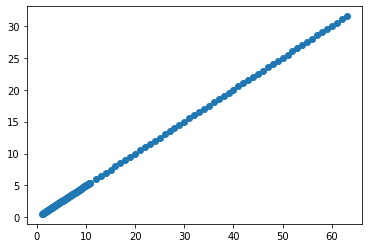

In [6]:
plt.scatter(orders,rdp)

In [7]:
rounds = range(1,10)
epsilon_range = np.array([get_privacy_spent(orders, i*rdp, target_delta=target_delta)[0] for i in rounds])

FL_rounds = int(np.sum(epsilon_range<max_eps))

In [8]:
model_args = {'DP': {'clip_threshold' : 1., 'epsilon' : epsilon_range[FL_rounds-1], 'sigma': target_delta}}

training_args = {
    'batch_size': 48, 
    'lr': 1e-3, 
    'fedprox_mu': 0.01, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

## Declare and run the experiment

- search nodes serving data for these `tags`, optionally filter on a list of node ID with `nodes`
- run a round of local training on nodes with model defined in `model_path` + federation with `aggregator`
- run for `round_limit` rounds, applying the `node_selection_strategy` between the rounds

In [9]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['#MNIST', '#dataset']

exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=FL_rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2022-03-11 18:45:33,858 fedbiomed INFO - Searching dataset with data tags: ['#MNIST', '#dataset'] for all nodes
2022-03-11 18:45:33,864 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Message received: {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'tags': ['#MNIST', '#dataset'], 'command': 'search'}
2022-03-11 18:45:43,862 fedbiomed INFO - Node selected for training -> node_5d59b59e-b156-495e-9423-c6a6fb9d5d42
2022-03-11 18:45:43,878 fedbiomed DEBUG - Model file has been saved: /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/my_model_53b200ff-c46a-420c-9745-c83721de68d9.py
2022-03-11 18:45:43,927 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/my_model_53b200ff-c46a-420c-9745-c83721de68d9.py successful, with status code 201
2022-03-11 18:45:44,302 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the nodes

In [10]:
exp.run()

2022-03-11 18:45:44,355 fedbiomed INFO - Sampled nodes in round 0 ['node_5d59b59e-b156-495e-9423-c6a6fb9d5d42']
2022-03-11 18:45:44,356 fedbiomed INFO - Send message to node node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 - {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'job_id': '7b4256e3-e0e0-4a4c-93f8-ee82fc92bdbc', 'training_args': {'batch_size': 48, 'lr': 0.001, 'fedprox_mu': 0.01, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100}, 'model_args': {'DP': {'clip_threshold': 1.0, 'epsilon': 14.697571214656923, 'sigma': 1.6666666666666667e-06}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/03/11/my_model_53b200ff-c46a-420c-9745-c83721de68d9.py', 'params_url': 'http://localhost:8844/media/uploads/2022/03/11/aggregated_params_init_079fc6fd-cedb-457a-9d8e-8ea288f14d6d.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_5d59b59e-b156-495e-9423-c6a6fb9d5d42': ['dataset_f2f1f2f2-ba6a-452d-bb03-b744e1ab4657']}}
2022-03-11 18:45:44,356 

2022-03-11 18:45:59,893 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Message received: {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'job_id': '7b4256e3-e0e0-4a4c-93f8-ee82fc92bdbc', 'training_args': {'batch_size': 48, 'lr': 0.001, 'fedprox_mu': 0.01, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100}, 'model_args': {'DP': {'clip_threshold': 1.0, 'epsilon': 14.697571214656923, 'sigma': 1.6666666666666667e-06}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/03/11/my_model_53b200ff-c46a-420c-9745-c83721de68d9.py', 'params_url': 'http://localhost:8844/media/uploads/2022/03/11/aggregated_params_99beb80d-5750-45e9-b4ca-9994025c4293.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_5d59b59e-b156-495e-9423-c6a6fb9d5d42': ['dataset_f2f1f2f2-ba6a-452d-bb03-b744e1ab4657']}}
2022-03-11 18:45:59,895 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - [TASKS QUEUE] Item:{'re

2022-03-11 18:46:15,464 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - upload (HTTP GET request) of file my_model_eb587274f6ab4a4db10c575ca7a12269.py successful, with status code 200
2022-03-11 18:46:15,603 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - upload (HTTP GET request) of file my_model_cf2e5402-fe5e-4354-ac56-0c7e787a8cef.pt successful, with status code 200
2022-03-11 18:46:15,621 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - training with arguments {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x135067940>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'batch_size': 48, 'lr': 0.001, 'fedprox_mu': 0.01, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100}
2022-03-11 18:46:15,622 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Dataset path has been set as/Users/mlorenzi/works/temp/MNIST
2022-03-11 18:46:15,623 f

2022-03-11 18:46:31,233 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [0/60000 (0%)]	Loss: 1.540959
2022-03-11 18:46:31,987 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [480/60000 (1%)]	Loss: 0.584365
2022-03-11 18:46:32,740 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [960/60000 (2%)]	Loss: 0.535584
2022-03-11 18:46:33,483 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [1440/60000 (2%)]	Loss: 0.440735
2022-03-11 18:46:34,229 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.368002
2022-03-11 18:46:34,977 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.440763
2022-03-11 18:46:35,719 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Tra

2022-03-11 18:46:52,083 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [3360/60000 (6%)]	Loss: 0.548930
2022-03-11 18:46:52,839 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.474770
2022-03-11 18:46:53,590 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [4320/60000 (7%)]	Loss: 0.641961
2022-03-11 18:46:54,351 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Reached 100 batches for this epoch, ignore remaining data
2022-03-11 18:46:54,352 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - running model.postprocess() method
2022-03-11 18:46:54,750 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/tmp/node_params_6fd9c132-4e0d-4d69-97fe-51396fc35334.pt successful, with

2022-03-11 18:47:17,048 fedbiomed INFO - Downloading model params after training on node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 - from http://localhost:8844/media/uploads/2022/03/11/node_params_0625d1cb-b515-4414-b234-017549002fe2.pt
2022-03-11 18:47:17,177 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_b03bdb55-79cd-46ac-8761-d786d6b12bd0.pt successful, with status code 200
2022-03-11 18:47:17,188 fedbiomed INFO - Nodes that successfully reply in round 5 ['node_5d59b59e-b156-495e-9423-c6a6fb9d5d42']
2022-03-11 18:47:17,566 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_62c362b1-6ba8-4e77-baf3-7131df64ef46.pt successful, with status code 201
2022-03-11 18:47:17,567 fedbiomed INFO - Saved aggregated params for round 5 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0006/aggregated_params_62c362b1-6ba8-4e77-baf3-7131df64ef46.pt


6

## Model trained without RDP-FL 

In [21]:
import torch
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from math import sqrt, log

# Here we define the model to be used. 
# You can use any class name (here 'Net')
class MyTrainingPlan_noRDP(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan_noRDP, self).__init__(model_args)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["from torchvision import datasets, transforms",
               "from torch.utils.data import DataLoader",
               "import torch",
               "from math import sqrt, log"]
        self.add_dependency(deps)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)      
        
        output = F.log_softmax(x, dim=1)
        return output

    def training_data(self, batch_size = 48):
        # Custom torch Dataloader for MNIST data
        transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
        dataset1 = datasets.MNIST(self.dataset_path, train=True, download=False, transform=transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        data_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        return data_loader
    
    def training_step(self, data, target):
        output = self.forward(data)
        loss   = torch.nn.functional.nll_loss(output, target)
        return loss

In [22]:
training_args = {
    'batch_size': 48, 
    'lr': 1e-3, 
    'fedprox_mu': 0.01, 
    'epochs': 1, 
    'dry_run': False,  
    'batch_maxnum': 100 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

In [23]:
tags =  ['#MNIST', '#dataset']


exp = Experiment(tags=tags,
                 #nodes=None,
#                 model_args=model_args,
                 model_class=MyTrainingPlan_noRDP,
                 training_args=training_args,
                 round_limit=FL_rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)


2022-03-11 18:53:56,873 fedbiomed INFO - Searching dataset with data tags: ['#MNIST', '#dataset'] for all nodes
2022-03-11 18:53:56,879 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Message received: {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'tags': ['#MNIST', '#dataset'], 'command': 'search'}
2022-03-11 18:54:06,879 fedbiomed INFO - Node selected for training -> node_5d59b59e-b156-495e-9423-c6a6fb9d5d42
2022-03-11 18:54:06,892 fedbiomed DEBUG - Model file has been saved: /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0010/my_model_50107e39-4abb-426e-80fe-b38cbe87613f.py
2022-03-11 18:54:06,944 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0010/my_model_50107e39-4abb-426e-80fe-b38cbe87613f.py successful, with status code 201
2022-03-11 18:54:07,317 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var

In [24]:
exp.run()

2022-03-11 18:54:17,041 fedbiomed INFO - Sampled nodes in round 0 ['node_5d59b59e-b156-495e-9423-c6a6fb9d5d42']
2022-03-11 18:54:17,042 fedbiomed INFO - Send message to node node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 - {'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'job_id': '6a0de441-6c3f-44fa-9aab-fd12ace8c506', 'training_args': {'batch_size': 48, 'lr': 0.001, 'fedprox_mu': 0.01, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100}, 'model_args': {}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/03/11/my_model_50107e39-4abb-426e-80fe-b38cbe87613f.py', 'params_url': 'http://localhost:8844/media/uploads/2022/03/11/aggregated_params_init_e3bb9aa3-d706-4119-a0f5-fee845f35636.pt', 'model_class': 'MyTrainingPlan_noRDP', 'training_data': {'node_5d59b59e-b156-495e-9423-c6a6fb9d5d42': ['dataset_f2f1f2f2-ba6a-452d-bb03-b744e1ab4657']}}
2022-03-11 18:54:17,043 fedbiomed DEBUG - researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50
2022-03-11 18:54:17,0

2022-03-11 18:54:32,576 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_3e4bd748-2b26-476a-9a88-05eb9d56df50', 'job_id': '6a0de441-6c3f-44fa-9aab-fd12ace8c506', 'params_url': 'http://localhost:8844/media/uploads/2022/03/11/aggregated_params_ba1a42ee-c476-4b9b-809c-5291eefe0bca.pt', 'training_args': {'batch_size': 48, 'lr': 0.001, 'fedprox_mu': 0.01, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100}, 'training_data': {'node_5d59b59e-b156-495e-9423-c6a6fb9d5d42': ['dataset_f2f1f2f2-ba6a-452d-bb03-b744e1ab4657']}, 'model_args': {}, 'model_url': 'http://localhost:8844/media/uploads/2022/03/11/my_model_50107e39-4abb-426e-80fe-b38cbe87613f.py', 'model_class': 'MyTrainingPlan_noRDP', 'command': 'train'}
2022-03-11 18:54:32,594 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - upload (HTTP GET request) of file my_model_21e3bb3660244a58b89e7d194f7e5399.py successful, with status code 2

2022-03-11 18:54:48,328 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - training with arguments {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x143f032e0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'batch_size': 48, 'lr': 0.001, 'fedprox_mu': 0.01, 'epochs': 1, 'dry_run': False, 'batch_maxnum': 100}
2022-03-11 18:54:48,329 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Dataset path has been set as/Users/mlorenzi/works/temp/MNIST
2022-03-11 18:54:48,331 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - Using device cpu for training (cuda_available=False, gpu=False, gpu_only=False, use_gpu=False, gpu_num=None)
2022-03-11 18:54:48,448 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [0/60000 (0%)]	Loss: 0.228645
2022-03-11 18:54:49,335 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO 

2022-03-11 18:55:06,511 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [1440/60000 (2%)]	Loss: 0.331070
2022-03-11 18:55:07,351 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.262553
2022-03-11 18:55:08,176 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.212488
2022-03-11 18:55:08,959 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.340561
2022-03-11 18:55:09,767 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [3360/60000 (6%)]	Loss: 0.432287
2022-03-11 18:55:10,522 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.474599
2022-03-11 18:55:11,340 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO 

2022-03-11 18:55:27,541 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - running model.postprocess() method
2022-03-11 18:55:27,542 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - model.postprocess() method not provided
2022-03-11 18:55:27,917 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/tmp/node_params_ad01c150-cf17-4d4b-b0c9-ce13303f02ac.pt successful, with status code 201
2022-03-11 18:55:27,919 fedbiomed INFO - log from: node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 / INFO - results uploaded successfully 
2022-03-11 18:55:34,305 fedbiomed INFO - Downloading model params after training on node_5d59b59e-b156-495e-9423-c6a6fb9d5d42 - from http://localhost:8844/media/uploads/2022/03/11/node_params_ad01c150-cf17-4d4b-b0c9-ce13303f02ac.pt
2022-03-11 18:55:34,430 fedbiomed DEBUG - upload (HTTP GET request) of file node_param

2022-03-11 18:55:50,358 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0010/aggregated_params_993ede89-fb21-446c-9638-e5c6fdfbf817.pt successful, with status code 201
2022-03-11 18:55:50,359 fedbiomed INFO - Saved aggregated params for round 5 in /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0010/aggregated_params_993ede89-fb21-446c-9638-e5c6fdfbf817.pt


6